## Library

In [1]:
from PIL import Image, ImageDraw, ImageFont

## `resize_image`

This function resizes an image to a width of 512 pixels while maintaining the aspect ratio by adjusting the height proportionally based on the original dimensions.

In [2]:
from PIL import Image

def resize_image(image: Image.Image) -> Image.Image:
    """
    Resizes the given image while maintaining the aspect ratio. The width is resized to 512 pixels,
    and the height is adjusted proportionally based on the original aspect ratio.

    Args:
        image: A PIL Image object to be resized.

    Returns:
        A resized PIL Image object with the width set to 512 pixels and the height adjusted
        to maintain the original aspect ratio.
    """
    # Calculate the new height maintaining the aspect ratio
    new_height = int(image.height * 512 / image.width)
    return image.resize((512, new_height))


This code opens an image file named 'grad_desc.jpg' using PIL, then resizes it using a defined function to maintain aspect ratio with a width of 512 pixels.

In [3]:
# Convert the image to PIL format and resize
pil_image = Image.open('test_image.png')
resized_image = resize_image(pil_image)

Display the image.

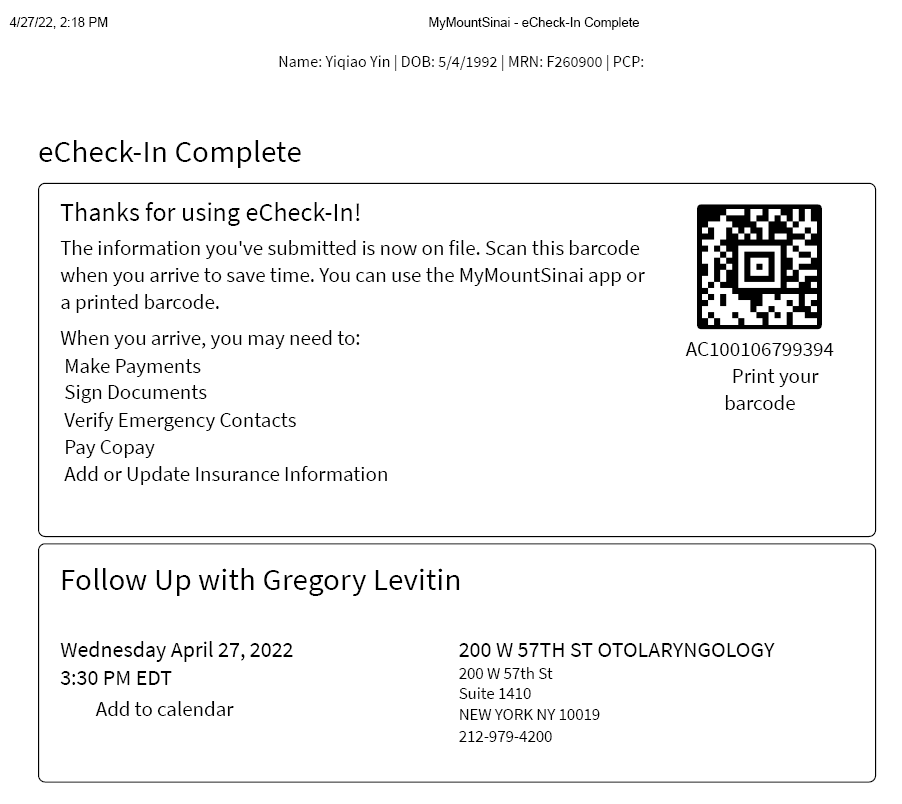

In [4]:
pil_image

## Library

In [5]:
import io
import os
import base64
from PIL import Image

## `convert_image_to_base64`

This function converts an image to a base64 encoded string, which is a way to represent binary data in an ASCII string format. It first saves the image to an in-memory bytes buffer in JPEG format, then encodes the contents of this buffer using base64 encoding and returns the result as a string.

In [7]:
def convert_image_to_base64(image: Image.Image) -> str:
    """
    Converts a PIL Image object to a base64-encoded string.

    Args:
        image: The PIL Image object to be converted to base64.

    Returns:
        A base64-encoded string representing the image.
    """
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()


In [8]:
# Convert the resized image to base64
image_base64 = convert_image_to_base64(resized_image)

In [9]:
from typing import Any, Dict, List
import requests
import json

## `post_request_and_parse_response`

This function, `post_request_and_parse_response`, is designed to facilitate sending HTTP POST requests to a specified URL with a JSON payload, and handling the response. It accepts a URL and a payload as inputs, where the payload is a dictionary of data to be sent. The function sets the appropriate headers to indicate the type of content being sent (in this case, JSON). It then uses the `requests` library to send the POST request to the given URL with the specified payload and headers. Upon receiving the response, the function reads the byte content of the response, decodes it from bytes to a UTF-8 string, and then parses this string from JSON format into a Python dictionary. This dictionary, which represents the structured response data, is then returned by the function, making it easier to interact with the response data programmatically within Python.

In [10]:
def post_request_and_parse_response(
    url: str, payload: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Sends a POST request to the specified URL with the given payload,
    then parses the byte response to a dictionary.
    Args:
    url (str): The URL to which the POST request is sent.
    payload (Dict[str, Any]): The payload to send in the POST request.
    Returns:
    Dict[str, Any]: The parsed dictionary from the response.
    """
    # Set headers for the POST request
    headers = {"Content-Type": "application/json"}

    # Send the POST request and get the response
    response = requests.post(url, json=payload, headers=headers)

    # Extract the byte data from the response
    byte_data = response.content

    # Decode the byte data to a string
    decoded_string = byte_data.decode("utf-8")

    # Convert the JSON string to a dictionary
    dict_data = json.loads(decoded_string)

    return dict_data

## API Call: `textract`

This code sends a base64-encoded image in a payload to a specified URL via a POST request and receives a response, which is parsed into a dictionary named `result_dict`.

In [11]:
url = "https://2tsig211e0.execute-api.us-east-1.amazonaws.com/my_textract"
payload = {"image": image_base64}
result_dict = post_request_and_parse_response(url, payload)

In [12]:
type(result_dict)

dict

## `draw_bounding_boxes_for_textract`

The `draw_bounding_boxes_for_textract` function annotates an image with bounding boxes, based on JSON data from Amazon Textract, which is a service that automatically extracts text and data from scanned documents. The function accepts a PIL Image object and a string of JSON data. It attempts to parse the JSON to identify the bounding box data (`'body'` field) for elements identified as lines or words (`'BlockType'`). For each identified element, it calculates the bounding box's position on the image and draws a red rectangle around it using `ImageDraw.Draw`. If successful, it returns the annotated PIL Image object; otherwise, it returns the original image, reporting errors if the JSON is invalid or lacks bounding box data.

In [13]:
def draw_bounding_boxes_for_textract(image: Image.Image, json_data: str) -> Image.Image:
    """
    Draws bounding boxes on an image based on the provided JSON data from Textract.
    Args:
        image_path: The path to the image on which to draw bounding boxes.
        json_data: The JSON string containing the bounding box data from Textract.
    Returns:
        A PIL Image object with bounding boxes drawn.
    """
    # Load the image from the provided path
    draw = ImageDraw.Draw(image)

    # Parse the JSON data
    try:
        data = json_data
        blocks = json.loads(data['body']) if 'body' in data else None
    except json.JSONDecodeError:
        print('Invalid JSON data.')
        return image

    if blocks is None:
        print('No bounding box data found.')
        return image

    # Iterate through the elements to find bounding boxes and draw them
    for item in blocks:
        if 'BlockType' in item and item['BlockType'] in ['LINE', 'WORD']:
            bbox = item['Geometry']['BoundingBox']
            # Extract coordinates and dimensions
            left, top, width, height = bbox['Left'], bbox['Top'], bbox['Width'], bbox['Height']
            # Calculate bounding box coordinates in image space
            left_top = (left * image.width, top * image.height)
            right_bottom = ((left + width) * image.width, (top + height) * image.height)
            # Draw rectangle
            draw.rectangle([left_top, right_bottom], outline='red', width=2)

    return image

Let's run the code and draw some bounding boxes.

In [14]:
image = pil_image
image_with_boxes = draw_bounding_boxes_for_textract(image.copy(), result_dict)

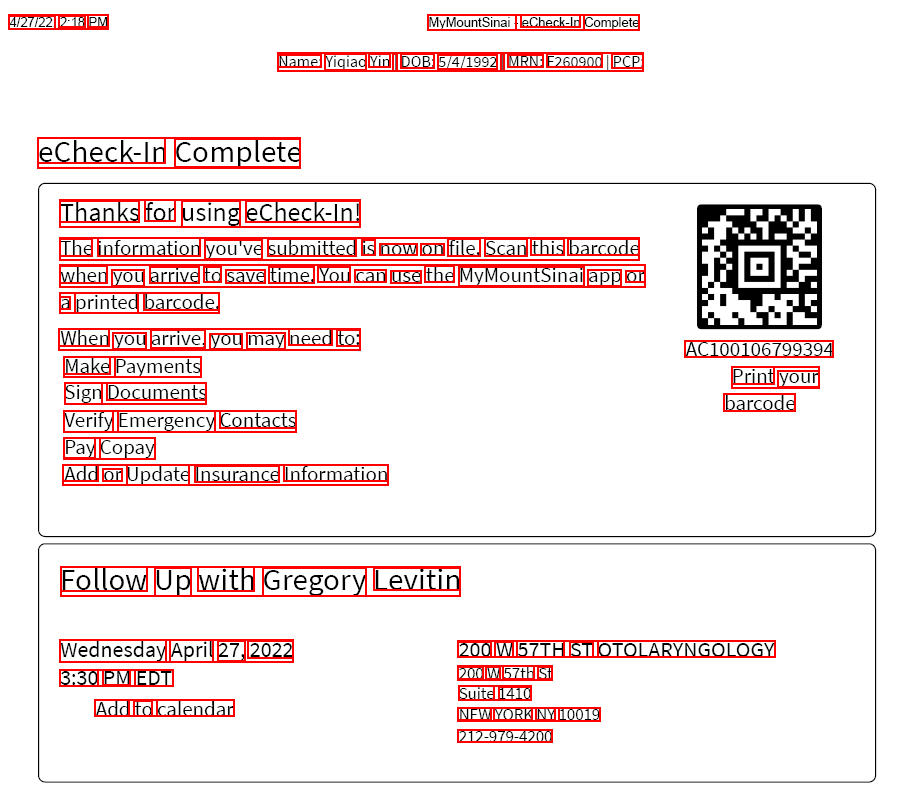

In [15]:
image_with_boxes

## Clean up `result_dict['body']`

In [58]:
from typing import List, Dict, Any

def extract_text_from_textract_blocks(blocks: List[Dict[str, Any]]) -> str:
    """
    Extracts and returns the concatenated text content from a list of AWS Textract blocks.

    The function processes a list of dictionaries, each representing a block of information from
    AWS Textract. It filters out non-text content and concatenates text from blocks where the
    `BlockType` is 'LINE' or 'WORD'.

    Args:
        blocks (List[Dict[str, Any]]): A list of block dictionaries returned by AWS Textract.

    Returns:
        str: A string containing the concatenated text from all relevant blocks.
    """
    # Initialize a list to hold the text content.
    extracted_text = []

    # Iterate over each block in the Textract output
    blocks = json.loads(blocks)
    for block in blocks:
        # Ensure the block is a dictionary
        if isinstance(block, dict):
            # Only extract text if the block contains the 'Text' key and the BlockType is 'LINE' or 'WORD'
            if block.get('BlockType') in ['LINE', 'WORD'] and 'Text' in block:
                # Append the text content to the list
                extracted_text.append(block['Text'])

    # Join the list of extracted text with spaces to form a single string.
    return ' '.join(extracted_text)


In [59]:
cleaned_up_body = extract_text_from_textract_blocks(result_dict['body'])

In [60]:
cleaned_up_body

"4/27/22 2:18 PM MyMountSinai eCheck-In Complete Name: Yigiao Yin I DOB: 5/4/1992 I MRN: F260900 PCP: eCheck-In Complete Thanks for using eCheck-In! The information you've submitted is now on file. Scan this barcode when you arrive to save time. You can use the MyMountSinai app or a printed barcode. When you arrive, you may need to: AC100106799394 Make Payments Print your Sign Documents barcode Verify Emergency Contacts Pay Copay Add or Update Insurance Information Follow Up with Gregory Levitin Wednesday April 27, 2022 200 W 57TH ST OTOLARYNGOLOGY 3:30 PM EDT 200 W 57th St Suite 1410 Add to calendar NEW YORK NY 10019 212-979-4200 4/27/22 2:18 PM MyMountSinai eCheck-In Complete Name: Yigiao Yin I DOB: 5/4/1992 I MRN: F260900 PCP: eCheck-In Complete Thanks for using eCheck-In! The information you've submitted is now on file. Scan this barcode when you arrive to save time. You can use the MyMountSinai app or a printed barcode. When you arrive, you may need to: AC100106799394 Make Payment

## Install `OpenAI`

In [ ]:
! pip install openai

In [17]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [27]:
from openai import OpenAI
from typing import List, Dict, Any

class ChatGPTClient:
    def __init__(self, api_key: str, protocol: str = "You are a helpful assistant.", body = None):
        """
        Initializes the ChatGPTClient with an OpenAI client and conversation history.

        Args:
            client (OpenAI): The OpenAI client initialized with an API key.
        """
        self.api_key = api_key
        self.client = OpenAI(api_key=self.api_key)
        self.protocol = protocol
        self.body = body
        self.history: List[Dict[str, str]] = [
            {"role": "system", "content": self.protocol},
            {"role": "user", "content": f"The content provided: {self.body}"}
        ]

    def get_history(self) -> List[Dict[str, str]]:
        """
        Returns the current conversation history.

        Returns:
            List[Dict[str, str]]: The list of message dictionaries containing the conversation history.
        """
        return self.history

    def append_message(self, role: str, content: str) -> None:
        """
        Appends a new message to the conversation history.

        Args:
            role (str): The role of the message sender. Can be "user", "system", or "assistant".
            content (str): The content of the message to be appended.
        """
        if role in ["system", "user", "assistant"]:
            self.history.append({"role": role, "content": content})
        else:
            raise ValueError(f"Invalid role: {role}. Role must be one of 'system', 'user', or 'assistant'.")

    def generate_response(self, question: str) -> str:
        """
        Sends the current conversation history to the GPT model and generates a response.

        Args:
            question (str): The question or message from the user to be sent to the GPT model.

        Returns:
            str: The generated response from the GPT model. If an error occurs, a default error message is returned.
        """
        try:
            # Append the user's question to the conversation history
            self.append_message("user", question)

            # Call the GPT model and generate a response
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=self.history
            )
            # Extract the assistant's response
            output = response.choices[0].message.content

            # Append the assistant's response to the conversation history
            self.append_message("assistant", output)
        except Exception as e:
            print(f"Error: {e}")
            output = "Sorry, I couldn't get an answer for that."

        return output


## Chat with Picture

OCR -> JSON Body -> Clean up -> RAG

In [63]:
bot = ChatGPTClient(
    api_key=OPENAI_API_KEY,
    protocol="You are fed with the text portion of json file that come out of OCR after scanning an image. User will ask you question about this json file.",
    body=cleaned_up_body
)

In [ ]:
bot.generate_response("Where do I meet with Greg Levitin?")

In [ ]:
bot.generate_response("What time do I meet with Greg Levitin?")

In [ ]:
bot.generate_response("What is the date do I meet with Greg Levitin?")